In [ ]:
import pandas as pd
import numpy as np
import os

input_file_paths = [
    r'F:\VERO UTENTE\Desktop\Uni\dissertation\main\K-fold\large-cross-entropy--5e-5\data_fold1\FIRST\FIRST_fold1_validation_split_predictions.csv',
    r'f:\VERO UTENTE\Desktop\Uni\dissertation\main\NO-fold\Grok\non-thinking\validation\grok-3-mini-latest_calculators_results.csv',
    r'F:\VERO UTENTE\Desktop\Uni\dissertation\main\NO-fold\Grok\thinking\validation\grok-3-mini-latest_calculators_results-temp=0.4.csv',
    r'f:\VERO UTENTE\Desktop\Uni\dissertation\main\NO-fold\DeepSeek\thinking\validation\deepseek-reasoner_calculators_ev_gemini_1.1_results-temp=0.5.csv',
    r'F:\VERO UTENTE\Desktop\Uni\dissertation\main\NO-fold\Google\non-thinking\validation\gemini-2.5-flash-preview-05-20_calculators_results.csv',
]

data_frames = [pd.read_csv(file_path) for file_path in input_file_paths]

# Check which column is used for indexing across the dataframes
# Assuming 'index' column exists in all dataframes
common_indices = set(data_frames[0]['index'])
for df in data_frames[1:]:
    common_indices.intersection_update(df['index'])

print(f"Number of common indices: {len(common_indices)}")
common_indices_list = sorted(list(common_indices))
print(f"First few common indices: {common_indices_list[:5]}")

CLASS_LABELS = ["indicator", "ideation", "behavior", "attempt"]
# Adjust weights to use all models (example weights)
weights = [0.7026, 0.750, 0.745, 0.774, 0.743]

# Create new dataframe with common samples
new_df = pd.DataFrame()
new_df['index'] = common_indices_list

# Get the original post and labels from the first dataframe
for idx in common_indices_list:
    mask = data_frames[0]['index'] == idx
    if any(mask):
        row_idx = mask.idxmax()
        if 'post' not in new_df.columns:
            new_df['post'] = ""
            new_df['labels'] = ""
        new_df.loc[new_df['index'] == idx, 'post'] = data_frames[0].loc[row_idx, 'post']
        new_df.loc[new_df['index'] == idx, 'labels'] = data_frames[0].loc[row_idx, 'labels']

# Create a weighted average of predictions
weighted_sum = np.zeros((len(common_indices_list), len(CLASS_LABELS)))

for i, df in enumerate(data_frames):
    for j, idx in enumerate(common_indices_list):
        mask = df['index'] == idx
        if any(mask):
            row_idx = mask.idxmax()
            pred = df.loc[row_idx, 'predicted_label']
            class_index = CLASS_LABELS.index(pred)
            weighted_sum[j, class_index] += weights[i]

# Determine final predictions
final_predictions = []
for i in range(len(common_indices_list)):
    max_index = np.argmax(weighted_sum[i])
    final_predictions.append(CLASS_LABELS[max_index])

# Add final predictions to the dataframe
new_df['predicted_label'] = final_predictions

# Save the combined predictions
output_path = r'F:\VERO UTENTE\Desktop\Uni\dissertation\main\K-fold\large-cross-entropy--5e-5\ensamble_explore\SECOND_ensemble_eval_predictions_fold1.csv'
new_df.to_csv(output_path, index=False)

print(f"Combined predictions saved to {output_path}")
print(f"Number of common samples across all models: {len(common_indices_list)}")

# Print a few example predictions
print("\nSample predictions:")
for i in range(min(5, len(new_df))):
    print(f"Index {new_df.iloc[i]['index']}: True={new_df.iloc[i]['labels']}, Predicted={new_df.iloc[i]['predicted_label']}")

Number of common indices: 100
First few common indices: [6, 13, 25, 27, 28]
Combined predictions saved to F:\VERO UTENTE\Desktop\Uni\dissertation\main\K-fold\large-cross-entropy--5e-5\ensamble_explore\SECOND_ensemble_eval_predictions_fold1.csv
Number of common samples across all models: 100

Sample predictions:
Index 6: True=behavior, Predicted=ideation
Index 13: True=ideation, Predicted=ideation
Index 25: True=ideation, Predicted=ideation
Index 27: True=indicator, Predicted=indicator
Index 28: True=ideation, Predicted=ideation


: 

In [2]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Define the path to your CSV file
# Using a raw string (r'...') is a good practice for file paths on Windows
file_path = r'F:\VERO UTENTE\Desktop\Uni\dissertation\main\K-fold\large-cross-entropy--5e-5\ensamble_explore\FIRST_ensemble_eval_predictions_fold1.csv'

def print_metrics(data_frame):
    print(f"\nNumber of examples: {len(data_frame)}")
    
    if not data_frame.empty:
        print("Proportion and number of examples per class:")
        
        # Get value counts and proportions
        counts = data_frame['labels'].value_counts()
        proportions = data_frame['labels'].value_counts(normalize=True)
        
        # Combine them for a prettier output
        for label, proportion in proportions.items():
            count = counts[label]
            print(f"{label}: {proportion:.2%} ({count})")
        print("-" * 30)

        # Extract the true labels and predicted labels from the DataFrame
        y_true = data_frame['labels']
        y_pred = data_frame['predicted_label']
        
        # Get the unique labels present in the data
        labels = sorted(pd.concat([y_true, y_pred]).unique())

        # Calculate accuracy
        accuracy = accuracy_score(y_true, y_pred)

        # Calculate weighted F1 score
        weighted_f1 = f1_score(y_true, y_pred, average='weighted', labels=labels, zero_division=0)

        # Calculate macro F1 score
        macro_f1 = f1_score(y_true, y_pred, average='macro', labels=labels, zero_division=0)

        # Generate a detailed classification report
        report = classification_report(y_true, y_pred, labels=labels, zero_division=0)

        # Print the calculated metrics
        print(f"\nMetrics for filtered data from: {file_path}\n")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Weighted F1 Score: {weighted_f1:.4f}")
        print(f"Macro F1 Score: {macro_f1:.4f}")
        print(report)
    else:
        print("\nNo examples in data_frame.")

df = pd.read_csv(file_path)
print_metrics(df)


Number of examples: 100
Proportion and number of examples per class:
ideation: 40.00% (40)
behavior: 27.00% (27)
indicator: 26.00% (26)
attempt: 7.00% (7)
------------------------------

Metrics for filtered data from: F:\VERO UTENTE\Desktop\Uni\dissertation\main\K-fold\large-cross-entropy--5e-5\ensamble_explore\FIRST_ensemble_eval_predictions_fold1.csv

Accuracy: 0.8200
Weighted F1 Score: 0.8134
Macro F1 Score: 0.8203
              precision    recall  f1-score   support

     attempt       0.78      1.00      0.88         7
    behavior       0.85      0.81      0.83        27
    ideation       0.76      0.95      0.84        40
   indicator       1.00      0.58      0.73        26

    accuracy                           0.82       100
   macro avg       0.85      0.84      0.82       100
weighted avg       0.85      0.82      0.81       100



Number of common indices: 100
First few common indices: [6, 13, 25, 27, 28]

Best weight for weights[0]: 0.0400
Weighted F1 score with best weight: 0.8153


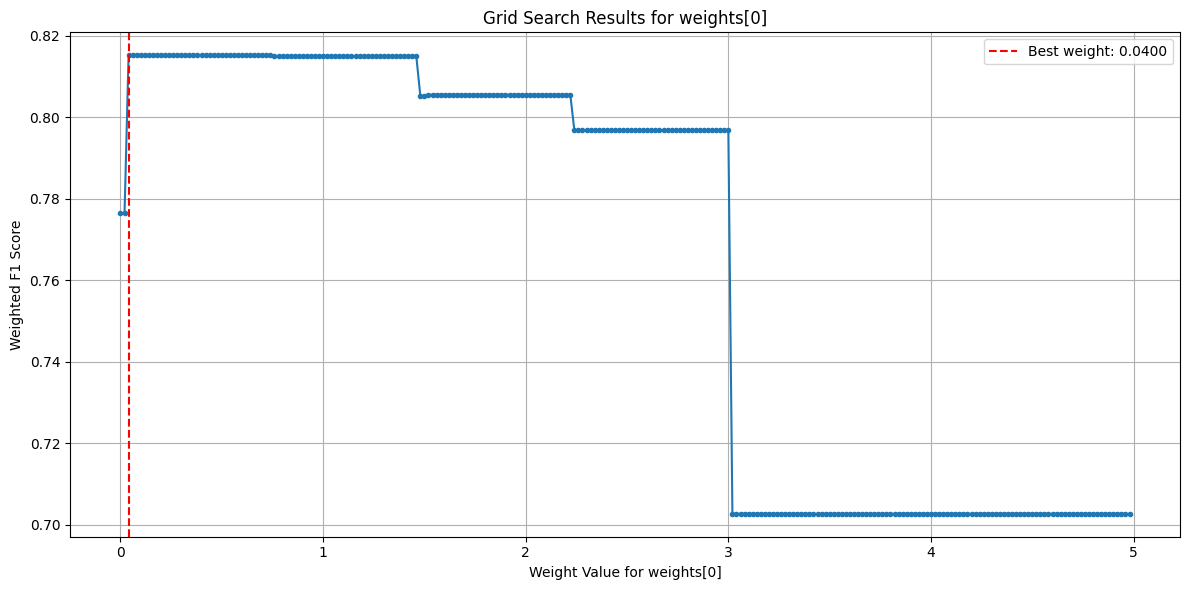

Number of common indices: 100
First few common indices: [2, 7, 9, 20, 21]

Best weight for weights[0]: 1.5400
Weighted F1 score with best weight: 0.7840


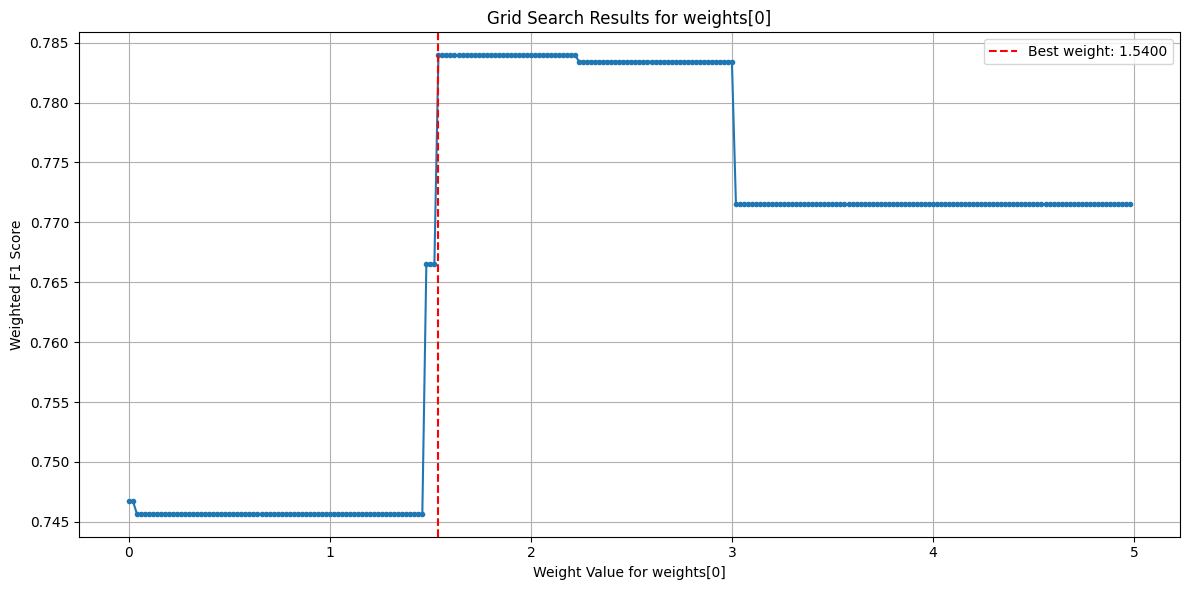

Number of common indices: 100
First few common indices: [0, 5, 11, 12, 15]

Best weight for weights[0]: 0.0000
Weighted F1 score with best weight: 0.8172


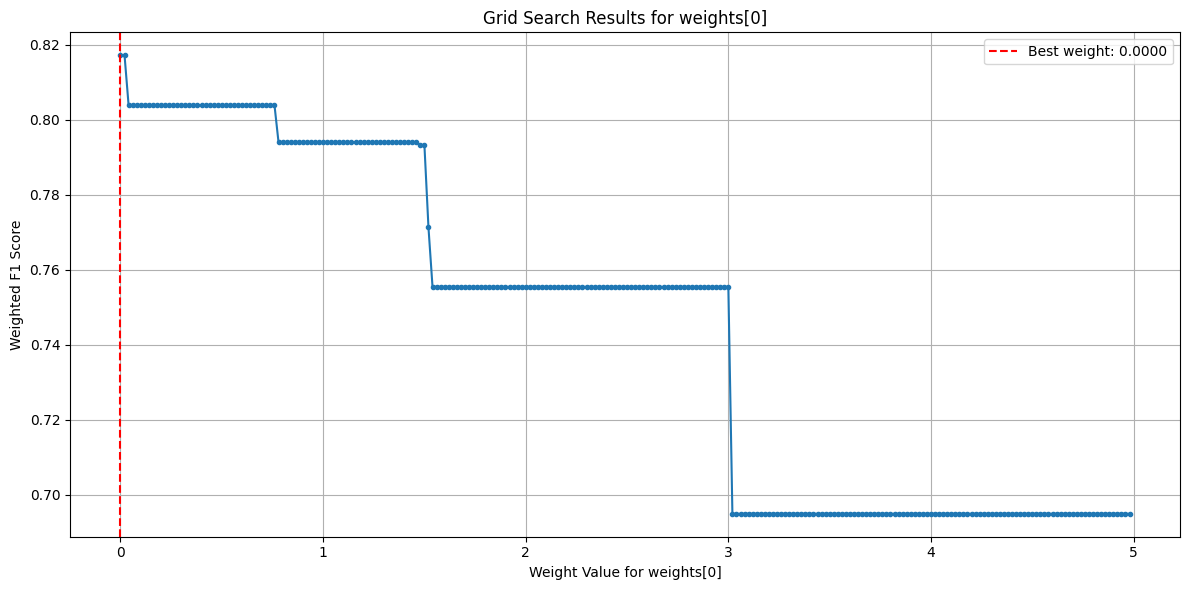

Number of common indices: 100
First few common indices: [3, 4, 8, 16, 19]

Best weight for weights[0]: 2.2400
Weighted F1 score with best weight: 0.8238


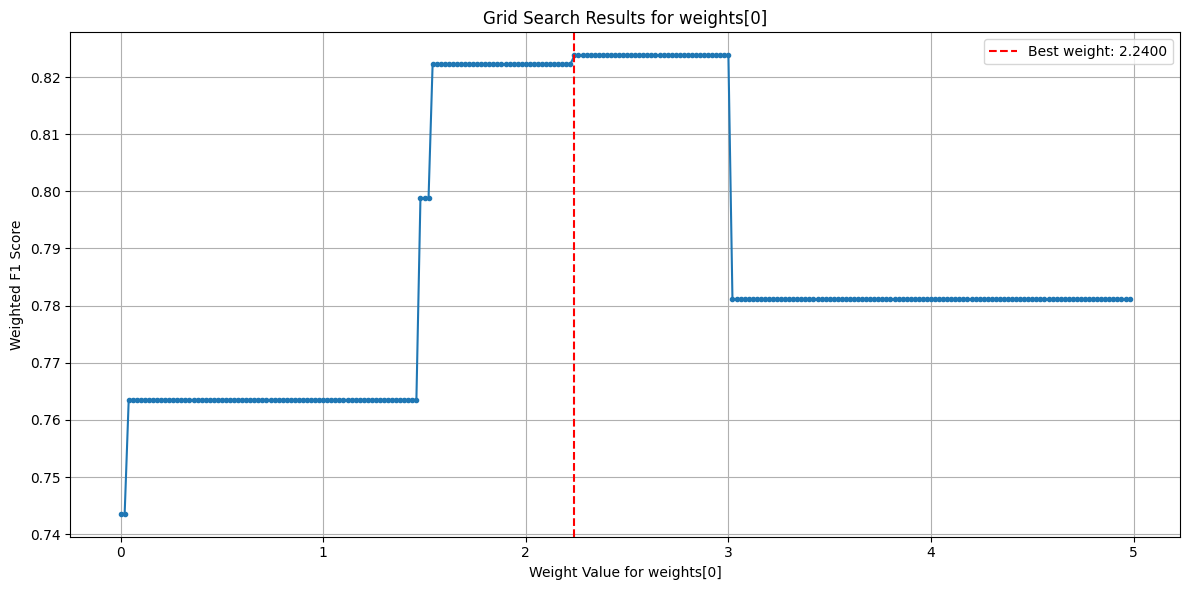

Number of common indices: 100
First few common indices: [1, 10, 14, 18, 23]

Best weight for weights[0]: 0.0000
Weighted F1 score with best weight: 0.7577


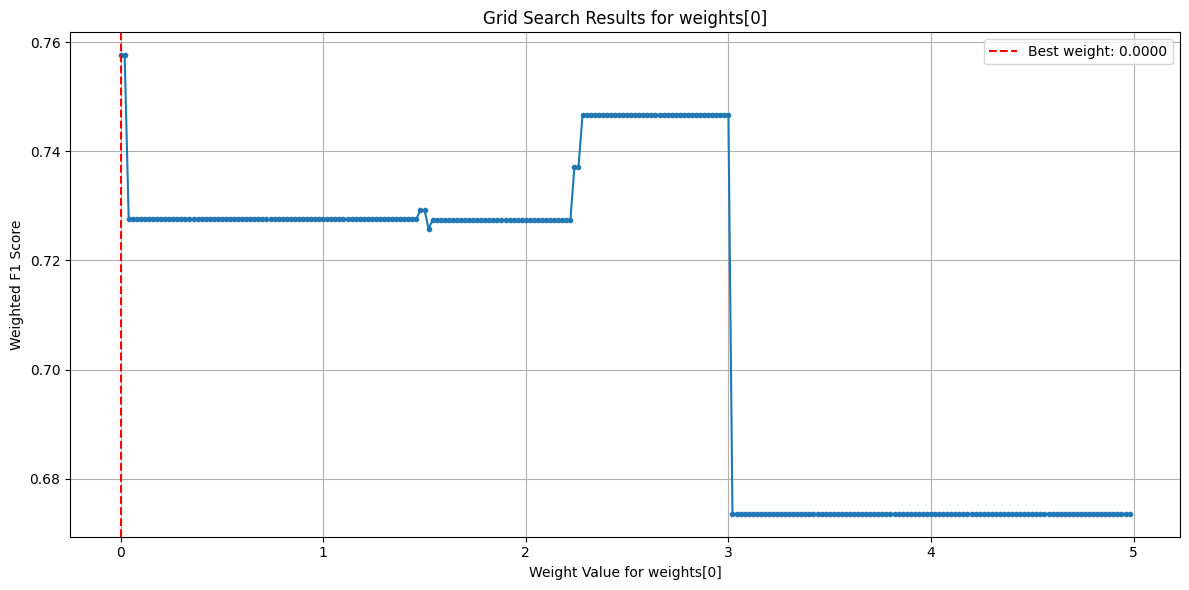

In [11]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

for number in range(1, 6):
    fold = 'fold' + str(number)

    input_file_paths = [
        #os.path.join(r'F:\VERO UTENTE\Desktop\Uni\dissertation\main\K-fold\large-cross-entropy--5e-5', 'data_' + fold, 'FIRST', 'FIRST_' + fold + '_validation_split_predictions.csv'),
        os.path.join(r'F:\VERO UTENTE\Desktop\Uni\dissertation\main\K-fold\large-cross-entropy--5e-5', 'data_' + fold, fold + '_validation_split_predictions.csv'),
        r'f:\VERO UTENTE\Desktop\Uni\dissertation\main\NO-fold\Grok\non-thinking\validation\grok-3-mini-latest_calculators_results.csv',
        r'F:\VERO UTENTE\Desktop\Uni\dissertation\main\NO-fold\Grok\thinking\validation\grok-3-mini-latest_calculators_results-temp=0.4.csv',
        r'f:\VERO UTENTE\Desktop\Uni\dissertation\main\NO-fold\DeepSeek\thinking\validation\deepseek-reasoner_calculators_ev_gemini_1.1_results-temp=0.5.csv',
        r'F:\VERO UTENTE\Desktop\Uni\dissertation\main\NO-fold\Google\non-thinking\validation\gemini-2.5-flash-preview-05-20_calculators_results.csv',
    ]

    data_frames = [pd.read_csv(file_path) for file_path in input_file_paths]

    # Check which column is used for indexing across the dataframes
    common_indices = set(data_frames[0]['index'])
    for df in data_frames[1:]:
        common_indices.intersection_update(df['index'])

    print(f"Number of common indices: {len(common_indices)}")
    common_indices_list = sorted(list(common_indices))
    print(f"First few common indices: {common_indices_list[:5]}")

    CLASS_LABELS = ["indicator", "ideation", "behavior", "attempt"]

    # Create new dataframe with common samples
    new_df = pd.DataFrame()
    new_df['index'] = common_indices_list

    # Get the original post and labels from the first dataframe
    for idx in common_indices_list:
        mask = data_frames[0]['index'] == idx
        if any(mask):
            row_idx = mask.idxmax()
            if 'post' not in new_df.columns:
                new_df['post'] = ""
                new_df['labels'] = ""
            new_df.loc[new_df['index'] == idx, 'post'] = data_frames[0].loc[row_idx, 'post']
            new_df.loc[new_df['index'] == idx, 'labels'] = data_frames[0].loc[row_idx, 'labels']

    # Define the grid search range for weights[0]
    weight_values = np.arange(0, 5, 0.02)
    f1_scores = []

    # Define fixed weights for other models
    fixed_weights = [0.750, 0.745, 0.774, 0.743]

    for weight_0 in weight_values:
        # Set current weights
        weights = [weight_0] + fixed_weights

        # Create a weighted average of predictions
        weighted_sum = np.zeros((len(common_indices_list), len(CLASS_LABELS)))

        for i, df in enumerate(data_frames):
            for j, idx in enumerate(common_indices_list):
                mask = df['index'] == idx
                if any(mask):
                    row_idx = mask.idxmax()
                    pred = df.loc[row_idx, 'predicted_label']
                    class_index = CLASS_LABELS.index(pred)
                    weighted_sum[j, class_index] += weights[i]

        # Determine final predictions
        final_predictions = []
        for i in range(len(common_indices_list)):
            max_index = np.argmax(weighted_sum[i])
            final_predictions.append(CLASS_LABELS[max_index])

        # Calculate weighted F1 score
        true_labels = new_df['labels'].tolist()
        weighted_f1 = f1_score(true_labels, final_predictions, average='weighted')
        f1_scores.append(weighted_f1)

    # Find the best weight value
    best_index = np.argmax(f1_scores)
    best_weight = weight_values[best_index]
    best_f1 = f1_scores[best_index]

    print(f"\nBest weight for weights[0]: {best_weight:.4f}")
    print(f"Weighted F1 score with best weight: {best_f1:.4f}")

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(weight_values, f1_scores, marker='o', markersize=3)
    plt.axvline(x=best_weight, color='r', linestyle='--', label=f'Best weight: {best_weight:.4f}')
    plt.grid(True)
    plt.xlabel('Weight Value for weights[0]')
    plt.ylabel('Weighted F1 Score')
    plt.title('Grid Search Results for weights[0]')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Save the results to a CSV file
    results_df = pd.DataFrame({
        'weight_0': weight_values,
        'weighted_f1': f1_scores
    })
    results_df.to_csv('BASE_grid_search_' + fold + '.csv', index=False)

In [13]:
# create csv with average results across the 5 folds
import pandas as pd
import os


# Initialize a DataFrame to hold the average results
average_results = pd.DataFrame()
# Loop through each fold and read the results
for i in range(1, 6):
    fold = 'fold' + str(i)
    file_path = f'BASE/BASE_grid_search_{fold}.csv'
    
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        if average_results.empty:
            average_results = df.copy()
        else:
            average_results['weighted_f1'] += df['weighted_f1']

# Average the results
average_results['weighted_f1'] /= 5
# Save the averaged results to a new CSV file
average_results.to_csv('BASE_grid_search_average.csv', index=False)

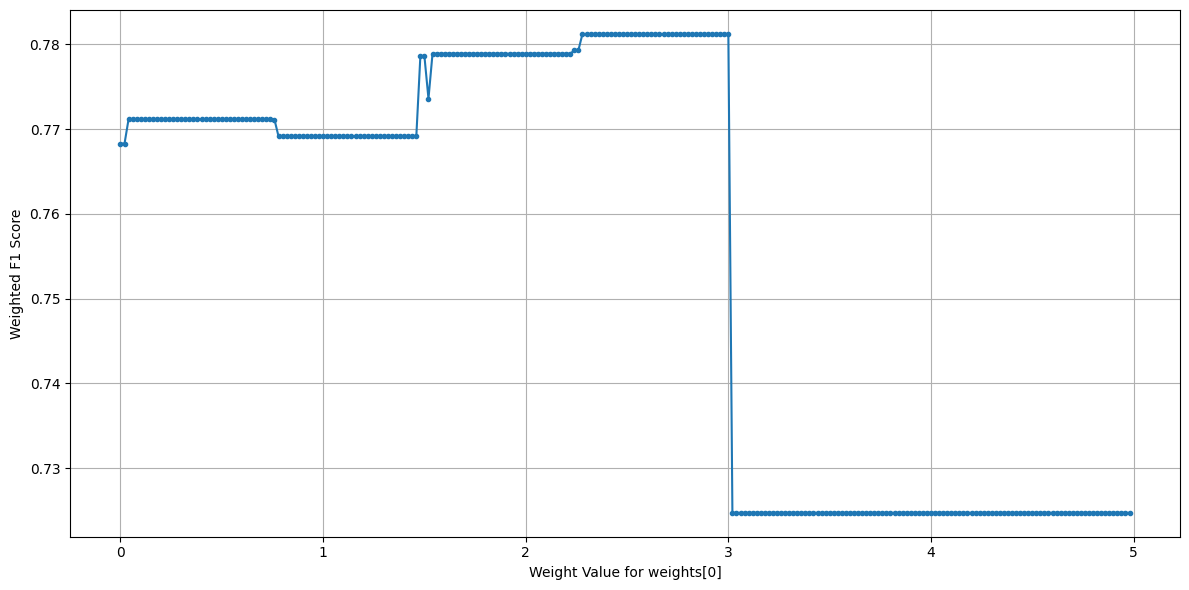

In [3]:
# plot F:\VERO UTENTE\Desktop\Uni\dissertation\main\K-fold\large-cross-entropy--5e-5\ensamble_explore\BASE\BASE_grid_search_average.csv
import pandas as pd
import matplotlib.pyplot as plt
# Load the averaged results
average_results = pd.read_csv(r'F:\VERO UTENTE\Desktop\Uni\dissertation\main\K-fold\large-cross-entropy--5e-5\ensamble_explore\BASE\BASE_grid_search_average.csv')
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(average_results['weight_0'], average_results['weighted_f1'], marker='o', markersize=3)
plt.grid(True)
plt.xlabel('Weight Value for weights[0]')
plt.ylabel('Weighted F1 Score')
#plt.title('Average Grid Search Results for RoBERTa weight')
plt.tight_layout()
plt.savefig('BASE_grid_search_average_plot.pdf')
plt.show()

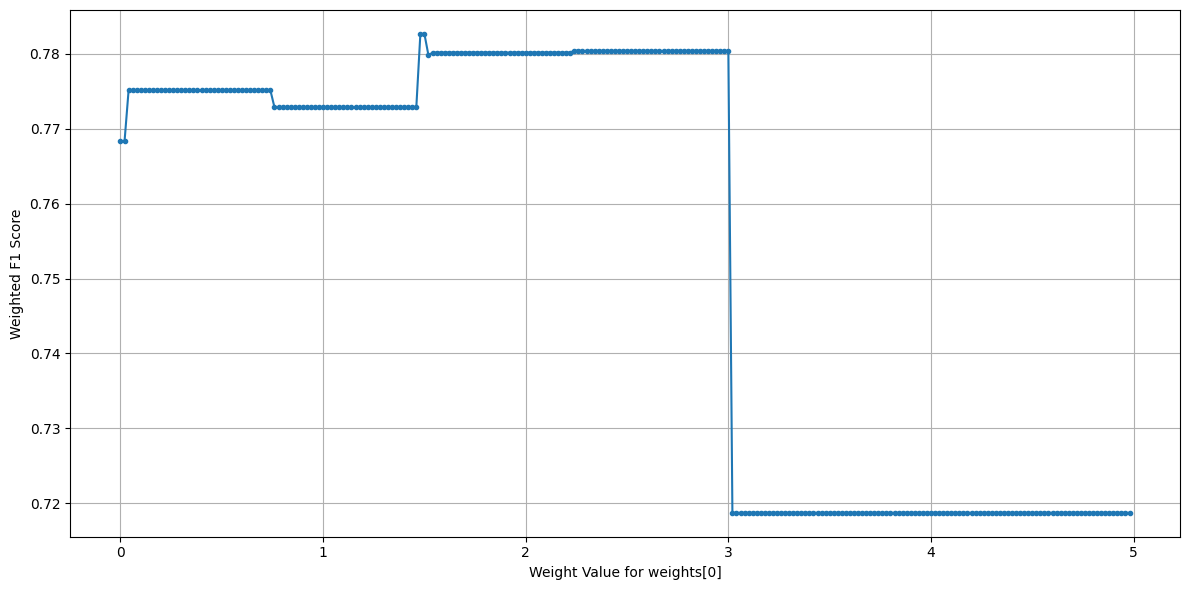

In [2]:
# plot F:\VERO UTENTE\Desktop\Uni\dissertation\main\K-fold\large-cross-entropy--5e-5\ensamble_explore\BASE\BASE_grid_search_average.csv
import pandas as pd
import matplotlib.pyplot as plt
# Load the averaged results
average_results = pd.read_csv(r'F:\VERO UTENTE\Desktop\Uni\dissertation\main\K-fold\large-cross-entropy--5e-5\ensamble_explore\FIRST\FIRST_grid_search_average.csv')
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(average_results['weight_0'], average_results['weighted_f1'], marker='o', markersize=3)
plt.grid(True)
plt.xlabel('Weight Value for weights[0]')
plt.ylabel('Weighted F1 Score')
#plt.title('Average Grid Search Results for weights[0]')
plt.tight_layout()
plt.savefig('FIRST_grid_search_average_plot.pdf')
plt.show()

In [ ]:
# plot F:\VERO UTENTE\Desktop\Uni\dissertation\main\K-fold\large-cross-entropy--5e-5\ensamble_explore\BASE\BASE_grid_search_average.csv
import pandas as pd
import matplotlib.pyplot as plt
# Load the averaged results
average_results = pd.read_csv(r'F:\VERO UTENTE\Desktop\Uni\dissertation\main\K-fold\large-cross-entropy--5e-5\ensamble_explore\FIRST\FIRST_grid_search_average.csv')
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(average_results['weight_0'], average_results['weighted_f1'], marker='o', markersize=3)
plt.grid(True)
plt.xlabel('Weight Value for weights[0]')
plt.ylabel('Weighted F1 Score')
#plt.title('Average Grid Search Results for weights[0]')
plt.tight_layout()
plt.savefig('FIRST_grid_search_average_plot.png')
plt.show()

Number of common indices: 100
First few common indices: [6, 13, 25, 27, 28]

Best weight for weights[0]: 0.0400
Weighted F1 score with best weight: 0.8134


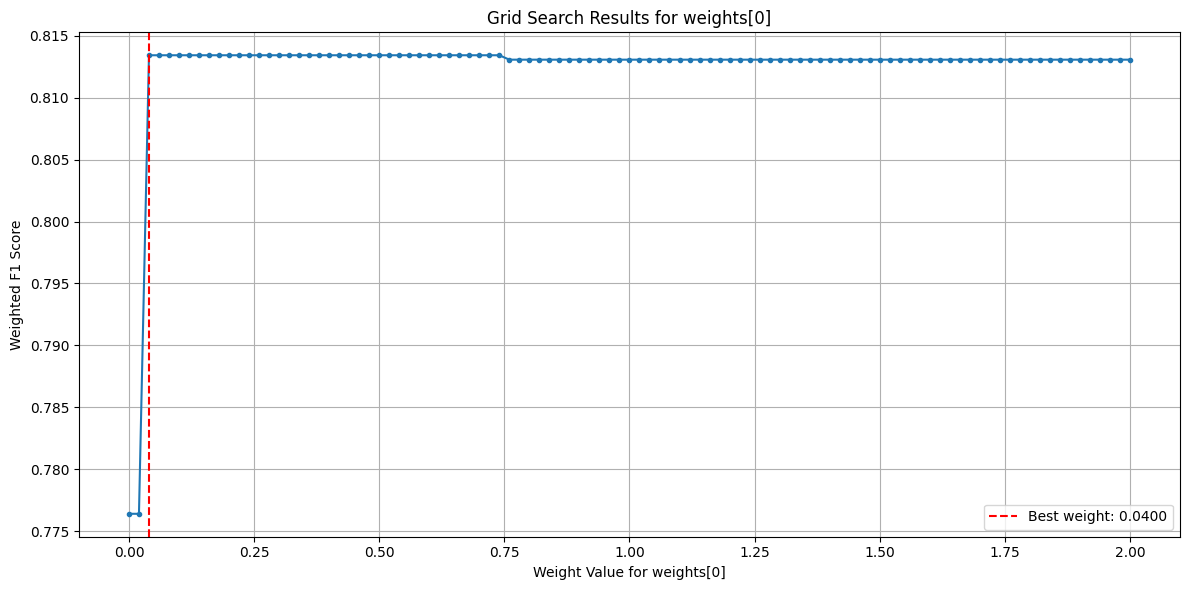

Results saved to 'grid_search_results.csv'


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

input_file_paths = [
    r'F:\VERO UTENTE\Desktop\Uni\dissertation\main\K-fold\large-cross-entropy--5e-5\data_fold1\FIRST\FIRST_fold1_validation_split_predictions.csv',
    r'f:\VERO UTENTE\Desktop\Uni\dissertation\main\NO-fold\Grok\non-thinking\validation\grok-3-mini-latest_calculators_results.csv',
    r'F:\VERO UTENTE\Desktop\Uni\dissertation\main\NO-fold\Grok\thinking\validation\grok-3-mini-latest_calculators_results-temp=0.4.csv',
    r'f:\VERO UTENTE\Desktop\Uni\dissertation\main\NO-fold\DeepSeek\thinking\validation\deepseek-reasoner_calculators_ev_gemini_1.1_results-temp=0.5.csv',
    r'F:\VERO UTENTE\Desktop\Uni\dissertation\main\NO-fold\Google\non-thinking\validation\gemini-2.5-flash-preview-05-20_calculators_results.csv',
]

data_frames = [pd.read_csv(file_path) for file_path in input_file_paths]

# Check which column is used for indexing across the dataframes
common_indices = set(data_frames[0]['index'])
for df in data_frames[1:]:
    common_indices.intersection_update(df['index'])

print(f"Number of common indices: {len(common_indices)}")
common_indices_list = sorted(list(common_indices))
print(f"First few common indices: {common_indices_list[:5]}")

CLASS_LABELS = ["indicator", "ideation", "behavior", "attempt"]

# Create new dataframe with common samples
new_df = pd.DataFrame()
new_df['index'] = common_indices_list

# Get the original post and labels from the first dataframe
for idx in common_indices_list:
    mask = data_frames[0]['index'] == idx
    if any(mask):
        row_idx = mask.idxmax()
        if 'post' not in new_df.columns:
            new_df['post'] = ""
            new_df['labels'] = ""
        new_df.loc[new_df['index'] == idx, 'post'] = data_frames[0].loc[row_idx, 'post']
        new_df.loc[new_df['index'] == idx, 'labels'] = data_frames[0].loc[row_idx, 'labels']

# Define the grid search range for weights[0]
weight_values = np.arange(0, 2.01, 0.02)
f1_scores = []

# Define fixed weights for other models
fixed_weights = [0.750, 0.745, 0.774, 0.743]

for weight_0 in weight_values:
    # Set current weights
    weights = [weight_0] + fixed_weights
    
    # Create a weighted average of predictions
    weighted_sum = np.zeros((len(common_indices_list), len(CLASS_LABELS)))

    for i, df in enumerate(data_frames):
        for j, idx in enumerate(common_indices_list):
            mask = df['index'] == idx
            if any(mask):
                row_idx = mask.idxmax()
                pred = df.loc[row_idx, 'predicted_label']
                class_index = CLASS_LABELS.index(pred)
                weighted_sum[j, class_index] += weights[i]

    # Determine final predictions
    final_predictions = []
    for i in range(len(common_indices_list)):
        max_index = np.argmax(weighted_sum[i])
        final_predictions.append(CLASS_LABELS[max_index])

    # Calculate weighted F1 score
    true_labels = new_df['labels'].tolist()
    weighted_f1 = f1_score(true_labels, final_predictions, average='weighted')
    f1_scores.append(weighted_f1)

# Find the best weight value
best_index = np.argmax(f1_scores)
best_weight = weight_values[best_index]
best_f1 = f1_scores[best_index]

print(f"\nBest weight for weights[0]: {best_weight:.4f}")
print(f"Weighted F1 score with best weight: {best_f1:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(weight_values, f1_scores, marker='o', markersize=3)
plt.axvline(x=best_weight, color='r', linestyle='--', label=f'Best weight: {best_weight:.4f}')
plt.grid(True)
plt.xlabel('Weight Value for weights[0]')
plt.ylabel('Weighted F1 Score')
plt.title('Grid Search Results for weights[0]')
plt.legend()
plt.tight_layout()
plt.show()

# Save the results to a CSV file
results_df = pd.DataFrame({
    'weight_0': weight_values,
    'weighted_f1': f1_scores
})
results_df.to_csv('grid_search_results.csv', index=False)

print("Results saved to 'grid_search_results.csv'")

In [ ]:
input_file_paths = [
    r'F:\VERO UTENTE\Desktop\Uni\dissertation\main\K-fold\large-cross-entropy--5e-5\data_fold3\FIRST\FIRST_pseudol_fold2.csv',
    r'F:\VERO UTENTE\Desktop\Uni\dissertation\main\NO-fold\Grok\non-thinking\predictions\grok-3-mini-latest_calculators_predictions.csv',
    r'F:\VERO UTENTE\Desktop\Uni\dissertation\main\NO-fold\DeepSeek\thinking\predictions\deepseek-reasoner_calculators_ev_gemini_1.1_predictions-temp=0.5.csv',
    r'F:\VERO UTENTE\Desktop\Uni\dissertation\main\NO-fold\Grok\thinking\predictions\grok-3-mini-latest_calculators_predictions-temp=0.4.csv',
    r'F:\VERO UTENTE\Desktop\Uni\dissertation\main\NO-fold\Google\non-thinking\pseudolabels\gemini-2.5-flash-preview-05-20_calculators_pseudolabels.csv',
]

data_frames = [pd.read_csv(file_path) for file_path in input_file_paths]

data_frames[0].head()

# Find common indices across all dataframes
common_indices = set(data_frames[0]['index'])
for df in data_frames[1:]:
    common_indices.intersection_update(df['index'])
common_indices_list = sorted(list(common_indices))
print(f"Number of common indices: {len(common_indices_list)}")
CLASS_LABELS = ["indicator", "ideation", "behavior", "attempt"]
# Create a new dataframe to store the results
new_df = pd.DataFrame()
new_df['index'] = common_indices_list
# Get the original post from the first dataframe
new_df['post'] = ""  # Initialize the 'post' column
for idx in common_indices_list:
    mask = data_frames[0]['index'] == idx
    if mask.any():
        row_idx = mask.idxmax()
        new_df.loc[new_df['index'] == idx, 'post'] = data_frames[0].loc[row_idx, 'post']
# Define fixed weights for the models
weights = [1.75, 0.750, 0.745, 0.774, 0.743]
    
# Calculate the weighted sum of predictions
weighted_sum = np.zeros((len(common_indices_list), len(CLASS_LABELS)))
for i, df in enumerate(data_frames):
    for j, idx in enumerate(common_indices_list):
        mask = df['index'] == idx
        if mask.any():
            row_idx = mask.idxmax()
            pred = df.loc[row_idx, 'predicted_label']
            if pred in CLASS_LABELS:
                class_index = CLASS_LABELS.index(pred)
                weighted_sum[j, class_index] += weights[i]
            else:
                print(f"Warning: label '{pred}' not in CLASS_LABELS for index {idx} in file {input_file_paths[i]}")
# Determine the final predictions based on the highest weighted sum
final_predictions = []
for i in range(len(common_indices_list)):
    max_index = np.argmax(weighted_sum[i])
    final_predictions.append(CLASS_LABELS[max_index])
# Add the final predictions to the new dataframe
new_df['predicted_label'] = final_predictions
# Display the head of the resulting dataframe
print(new_df.head())
# Save the dataframe to a CSV file
output_path = r'F:\VERO UTENTE\Desktop\Uni\dissertation\main\K-fold\large-cross-entropy--5e-5\data_fold2\ENSEMBLE\ensemble_predictions_fold2.csv'
new_df.to_csv(output_path, index=False)
print(f"\nFinal predictions saved to {output_path}")


Number of common indices: 1499
   index                                               post predicted_label
0    500  Why can’t I function in the world at all? I’m ...        ideation
1    501  i'm disgusting and filthy i deserve to fucking...        ideation
2    502  Just drugging myself to death Whooopeee nobody...        behavior
3    503  Really upset rn  On top of this he is barely a...       indicator
4    504  I’m done with life I can’t do this anymore. Ev...        ideation

Final predictions saved to F:\VERO UTENTE\Desktop\Uni\dissertation\main\K-fold\large-cross-entropy--5e-5\data_fold2\ENSEMBLE\ensemble_predictions_fold2.csv
